In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quadprog
import Classifier
import kernels
import challengeFunctions as cf


## check that the SVM work correctly

### Create dataset

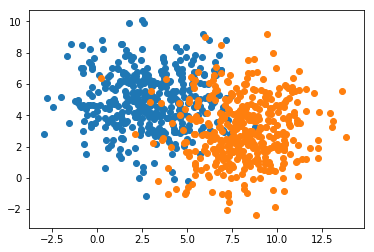

In [2]:
x1 = int(10*np.random.rand())
y1 = int(10*np.random.rand())
x2 = int(10*np.random.rand())
y2 = x1 = int(10*np.random.rand())
X11 = 2*np.random.randn(400) + x1
X12 = 2*np.random.randn(400) + y1

X21 = 2*np.random.randn(400) + x2
X22 = 2*np.random.randn(400) + y2
plt.figure()
plt.scatter(X11,X12)
plt.scatter(X21,X22)
plt.show()

In [3]:
X1 = np.vstack([X11, X12]).T# 100*np.ones(400)]).T
X2 = np.vstack([X21, X22]).T# 100*np.ones(400)]).T
Y =  np.hstack([np.ones(400), -np.ones(400)])
X = np.vstack([X1,X2])

### Define a display result fuction for different Kernels

In [4]:
def display_result(X,Y_true, svm):
    xmax = np.max(X[:,0])
    xmin = np.min(X[:,0])
    ymax = np.max(X[:,1])
    ymin = np.min(X[:,1])
    x = np.linspace(xmin, xmax, 10)
    y = np.linspace(ymin, ymax, 10)
    plt.figure()
    Xid, Y = np.meshgrid(x, y)
    Z = np.zeros((10,10))
    
    for kx in range(10):
        for ky in range(10) :
            
            Z[kx,ky] = svm.predict(np.array([[x[ky],y[kx]]]))
            
    plt.contourf(Xid, Y, Z, 20, cmap='RdGy')
    plt.colorbar()
    plt.contour(Xid, Y, Z, levels = 0,  colors='black')
    
    X1 = X[Y_true == 1]
    X2 = X[Y_true == -1]
    plt.scatter(X1[:,0],X1[:,1], c='red')
    plt.scatter(X2[:,0],X2[:,1], c= 'black')
    plt.show()
            
        
    

loss : 0.6931471805599452
loss : 0.37640614069235706
loss : 0.40108387193210054
Error, increasing loss
Training done in 0.4210019111633301s
score =  0.875


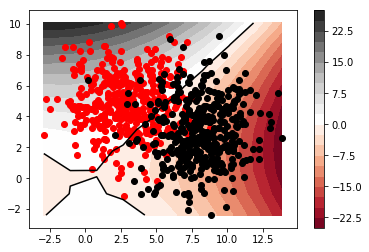

In [5]:
# learn classifier on the data

svm = Classifier.SVM("polynomial")
svm.lamb = 1
svm.train(X,Y)
Ytest = svm.predict(X)

# compute the score
pred = Ytest > 0
pred = 2*pred -1
score = np.sum(pred == Y)/800
print ('score = ', score)

#plot the decisison boundary
display_result(X, Y, svm)

## Test the Baseline

In [6]:
#first we try the baseline
def train_logreg(X,y):
    n = X.shape[0]
    p = X.shape[1]

    omega=np.zeros(p)

    while True:
        eta=1 / (1 + np.exp(np.clip(-X @ omega,-10,10)))

        D_eta=np.diag(eta*(1-eta))

        hessian = np.linalg.inv( X.T @ D_eta @ X )
        add = hessian @ X.T @ (y - eta)
        if np.sum(add >=1e-8) == 0:
            break
        omega = omega + add

    return omega

for i in range(1):
    Xf = np.genfromtxt('../data/Xtr{}_mat50.csv'.format(i))
    yf = np.genfromtxt('../data/Ytr{}.csv'.format(i),skip_header = 1,delimiter = ',')[:,1]
    omega = train_logreg(Xf,yf)

    y_pred = np.ones(Xf.shape[0])
    y_pred[Xf @ omega < 0] = 0
    print("Training accuracy : {}".format(cf.classification_accuracy(y_pred, yf))) 

Training accuracy : 0.644


In [7]:
X = cf.extractdata('../data/Xtr0_mat50.csv', sep = ' ')
Y = cf.extractdata('../data/Ytr0.csv')[1:,1]
Y = Y.astype(int)

In [8]:
Xtrain, Y_train, Xtest, Y_test = cf.splitdata(X,Y)
Xftrain, Yf_train, Xftest, Yf_test = cf.splitdata(Xf,yf)

In [9]:

omega = train_logreg(Xftrain,Yf_train)

y_pred = np.ones(Xftest.shape[0])
y_pred[Xftest @ omega < 0] = 0
print("Training accuracy : {}".format(cf.classification_accuracy(Yf_test, y_pred)))

Training accuracy : 0.596


In [13]:
train_acc = []
test_acc = []
lambs = [1e-8,1e-7,1e-6,1e-5]
for lamb in lambs:
    svm = Classifier.SVM("linear")
    svm.lamb = lamb

    Y_train_svm = 2*(Y_train - 1/2)
    Y_test_svm = 2*(Y_test - 1/2)
    svm.train(Xtrain, Y_train_svm)
    y_pred = svm.predict(Xtrain)
    y_pred = y_pred > 0
    train_acc.append(cf.classification_accuracy(Y_train, y_pred))
    y_pred = svm.predict(Xtest)
    y_pred = y_pred > 0
    test_acc.append(cf.classification_accuracy(Y_test, y_pred))



loss : 0.6931471805599453
loss : 0.6931467135045751
loss : 0.6931467135045934
Training done in 2.288879156112671s
loss : 0.6931471805599453
loss : 0.6931425114081928
loss : 0.6931425114264347
Training done in 2.226433038711548s
loss : 0.6931471805599453
loss : 0.6931006253380215
loss : 0.6931006412370629
loss : 0.6931006445520497
Training done in 2.886573076248169s
loss : 0.6931471805599453
loss : 0.6926926798064
loss : 0.6926981998379103
loss : 0.6927074306171178
loss : 0.6927168136944307
loss : 0.6927249342648527
loss : 0.6927314386232603
loss : 0.6927364299007257
loss : 0.6927401622064259
loss : 0.6927429074021054
loss : 0.692744904668088
loss : 0.6927463471197537
loss : 0.6927473836303275
loss : 0.6927481258395153
loss : 0.6927486560128094
loss : 0.6927490340764074
loss : 0.6927493033462022
loss : 0.6927494949659908
loss : 0.6927496312457608
loss : 0.6927497281264346
loss : 0.6927497969776516
loss : 0.6927498458983883
loss : 0.6927498806526702
loss : 0.6927499053401514
loss : 0.692

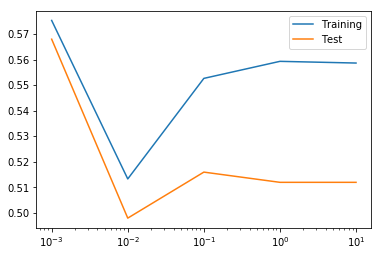

In [14]:
plt.semilogx(lambs,train_acc)
plt.semilogx(lambs,test_acc)
plt.legend(["Training",'Test'])
plt.show()